下面是代码的整个结构目录:

【1.用来存放自定义图片的目录——/home/aistudio/images/face】 

【2.用来存放图像列表的目录——/home/aistudio/face/】 

【3.model_vgg用来存放vgg网络训练的模型】 

【4.model_cnn用来存放cnn网路训练的模型】
![](https://ai-studio-static-online.cdn.bcebos.com/ec27dd0e36794f0c90936f0b6d88ddabfa5a14add56e4ebb93369565c8a67e88)

用%pwd查看当前所在目录

In [14]:
# %pwd

In [15]:
#解压数据集
# !unzip -qo /home/aistudio/data/data12039/images.zip -d /home/aistudio/ 

In [16]:
# !ls /home/aistudio/images/face

![](https://ai-studio-static-online.cdn.bcebos.com/0bcbe4f92cf44d7fa105848c056aeadba8d06ae1dc6d4b91b5deea0c9580a489)

# Step1：准备数据。

#### 数据集介绍
数据集中章子怡、姜文、彭于晏三位明星的人脸图片。
总计317张图片，章子怡100张，姜文103张，彭于晏114张。按照9:1的比例进行划分，90%用于训练，10%用于测试。

自定义的数据集，首先要生成图像列表，把自定的图像分为测试集和训练集，并带有标签。下面的程序可以单独运行，只要把一个大类的文件夹路径传进去就可以了,该程序会把里面的每个小类别都迭代,生成固定格式的列表.比如我们把人脸类别的根目录传进去../images/face。最后会在指定目录下面生成三个文件，readme.json、trainer.list和test.list.

In [4]:
import os
import json

# 设置要生成文件的路径
data_root_path = 'E:\\Code\\Notebook\\FaceR\\face_y'
# 所有类别的信息
class_detail = []
# 获取所有类别保存的文件夹名称，这里是['zhangziyi', 'jiangwen', 'pengyuyan']
class_dirs = os.listdir(data_root_path)
# 类别标签
class_label_dict = {'douwentao': 0, 'liangwendao': 1, 'majiahui': 2, 'zhouyijun': 3}
# 获取总类别的名称
father_paths = data_root_path.split('/')    #['', 'home', 'aistudio', 'images', 'face']
while True:
    if father_paths[father_paths.__len__() - 1] == '':
        del father_paths[father_paths.__len__() - 1]
    else:
        break
father_path = father_paths[father_paths.__len__() - 1]
# 把生产的数据列表都放在自己的总类别文件夹中
data_list_path = '%s/' % father_path
# 如果不存在这个文件夹,就创建
isexist = os.path.exists(data_list_path)
if not isexist:
    os.makedirs(data_list_path)
# 清空原来的数据
with open(data_list_path + "test.list", 'w') as f:
    pass
with open(data_list_path + "trainer.list", 'w') as f:
    pass
# 总的图像数量
all_class_images = 0
# 读取每个类别
for class_dir in class_dirs:
    # 每个类别的信息
    class_detail_list = {}
    test_sum = 0
    trainer_sum = 0
    # 统计每个类别有多少张图片
    class_sum = 0
    # 获取类别路径
    path = data_root_path + "/" + class_dir
    # 获取所有图片
    img_paths = os.listdir(path)

    for img_path in img_paths:                                  # 遍历文件夹下的每个图片
        name_path = path + '/' + img_path                       # 每张图片的路径
        if class_sum % 10 == 0:                                 # 每10张图片取一个做测试数据
            test_sum += 1                                       #test_sum测试数据的数目
            with open(data_list_path + "test.list", 'a') as f:
                f.write(name_path + "\t%d" % class_label_dict[class_dir] + "\n") #class_label 标签：0,1,2
        else:
            trainer_sum += 1                                    #trainer_sum测试数据的数目
            with open(data_list_path + "trainer.list", 'a') as f:
                f.write(name_path + "\t%d" % class_label_dict[class_dir] + "\n")#class_label 标签：0,1,2
        class_sum += 1                                          #每类图片的数目
        all_class_images += 1                                   #所有类图片的数目

    # 说明的json文件的class_detail数据
    class_detail_list['class_name'] = class_dir             #类别名称，如jiangwen
    class_detail_list['class_label'] = class_label_dict[class_dir]          #类别标签，0,1,2
    class_detail_list['class_test_images'] = test_sum       #该类数据的测试集数目
    class_detail_list['class_trainer_images'] = trainer_sum #该类数据的训练集数目
    class_detail.append(class_detail_list)         

# 获取类别数量
all_class_sum = class_dirs.__len__()
# 说明的json文件信息
readjson = {}
readjson['all_class_name'] = father_path                  #文件父目录
readjson['all_class_sum'] = all_class_sum                #
readjson['all_class_images'] = all_class_images
readjson['class_detail'] = class_detail
jsons = json.dumps(readjson, sort_keys=True, indent=4, separators=(',', ': '))
with open(data_list_path + "readme.json",'w') as f:
    f.write(jsons)
print ('生成数据列表完成！')
print ("标签及其类别：{}".format(class_label_dict))



生成数据列表完成！
标签及其类别：{'douwentao': 0, 'liangwendao': 1, 'majiahui': 2, 'zhouyijun': 3}


In [5]:
# ls /home/aistudio/face/

In [6]:
# cat /home/aistudio/face/readme.json

In [7]:
#导入要用到的模块
import paddle
import paddle.fluid as fluid
import numpy
import sys
import os
from multiprocessing import cpu_count
import matplotlib.pyplot as plt

train_reader和test_reader分别用于获取训练集和测试集
paddle.reader.shuffle()表示每次缓存BUF_SIZE个数据项，并进行打乱
paddle.batch()表示每BATCH_SIZE组成一个batch

自定义数据集需要先定义自己的reader，把图像数据处理一些，并输出图片的数组和标签。

In [8]:
# 定义训练的mapper
# train_mapper函数的作用是用来对训练集的图像进行处理修剪和数组变换，返回img数组和标签 
# sample是一个python元组，里面保存着图片的地址和标签。 ('../images/face/zhangziyi/20181206145348.png', 2)
def train_mapper(sample):
    img, label = sample
    # 进行图片的读取，由于数据集的像素维度各不相同，需要进一步处理对图像进行变换
    img = paddle.dataset.image.load_image(img)       
    #进行了简单的图像变换，这里对图像进行crop修剪操作，输出img的维度为(3, 100, 100)
    img = paddle.dataset.image.simple_transform(im=img,          #输入图片是HWC   
                                                resize_size=100, # 剪裁图片
                                                crop_size=100, 
                                                is_color=True,  #彩色图像
                                                is_train=True)
    #将img数组进行进行归一化处理，得到0到1之间的数值
    img= img.flatten().astype('float32')/255.0
    return img, label
# 对自定义数据集创建训练集train的reader
def train_r(train_list, buffered_size=1024):
    def reader():
        with open(train_list, 'r') as f:
            # 将train.list里面的标签和图片的地址方法一个list列表里面，中间用\t隔开'
            #../images/face/jiangwen/0b1937e2-f929-11e8-8a8a-005056c00008.jpg\t0'
            lines = [line.strip() for line in f]
            for line in lines:
                # 图像的路径和标签是以\t来分割的,所以我们在生成这个列表的时候,使用\t就可以了
                img_path, lab = line.strip().split('\t')
                yield img_path, int(lab) 
    # 创建自定义数据训练集的train_reader
    return paddle.reader.xmap_readers(train_mapper, reader,cpu_count(), buffered_size)

# sample是一个python元组，里面保存着图片的地址和标签。 ('../images/face/zhangziyi/20181206145348.png', 2)
def test_mapper(sample):
    img, label = sample
    img = paddle.dataset.image.load_image(img)
    img = paddle.dataset.image.simple_transform(im=img, resize_size=100, crop_size=100, is_color=True, is_train=False)
    img= img.flatten().astype('float32')/255.0
    return img, label

# 对自定义数据集创建验证集test的reader
def test_r(test_list, buffered_size=1024):
    def reader():
        with open(test_list, 'r') as f:
            lines = [line.strip() for line in f]
            for line in lines:
                #图像的路径和标签是以\t来分割的,所以我们在生成这个列表的时候,使用\t就可以了
                img_path, lab = line.strip().split('\t')
                yield img_path, int(lab)

    return paddle.reader.xmap_readers(test_mapper, reader,cpu_count(), buffered_size)

对比一下手写数字识别和猫狗分类创建reader的代码
![](https://ai-studio-static-online.cdn.bcebos.com/b631dde4c5ca42718830a0046fcb6f93a3844372590d465fa4f5c7729ca39f49)
![](https://ai-studio-static-online.cdn.bcebos.com/e10ca507a3db4cd781bd9885dda593436dfcaed40f7e4408a27d9c506df61d04)

In [9]:
BATCH_SIZE = 32
# 把图片数据生成reader
trainer_reader = train_r(train_list="E:\\Code\\Notebook\\FaceR\\face_y\\trainer.list")
train_reader = paddle.batch(
    paddle.reader.shuffle(
        reader=trainer_reader,buf_size=400),
    batch_size=BATCH_SIZE)

tester_reader = test_r(test_list="E:\\Code\\Notebook\\FaceR\\face_y\\test.list")
test_reader = paddle.batch(
     tester_reader, batch_size=BATCH_SIZE)

打印看下数据是什么样的？PaddlePaddle接口提供的数据已经经过了归一化、居中等处理
尝试打印一下，观察一下自定义的数据集

In [10]:
train_data = paddle.batch(trainer_reader,
                            batch_size=3)
sampledata=next(train_data())
print(sampledata)

[(array([0.02745098, 0.02745098, 0.03529412, ..., 0.10980392, 0.25882354,
       0.44705883], dtype=float32), 0), (array([0.01960784, 0.01176471, 0.01568628, ..., 0.00784314, 0.02352941,
       0.05098039], dtype=float32), 0), (array([0.05882353, 0.05882353, 0.05882353, ..., 0.07058824, 0.13333334,
       0.12941177], dtype=float32), 0)]


![](https://ai-studio-static-online.cdn.bcebos.com/a069c92213f2435590f860ab0191a41b5d37aa075e5f4da6b3815e2efc012ea9)

# Step2.网络配置

（1）搭建网络

配置网络主要是用来组建一个Program，主要包括三个部分：1.网络模型2.损失函数3.优化函数

搭建的CNN网络

![](https://ai-studio-static-online.cdn.bcebos.com/c5424f9fb8b1426b94011486724e44be88812b41413f4a40a38ccec5810b879d)

In [11]:
def convolutional_neural_network(image, type_size):
    # 第一个卷积--池化层
    conv_pool_1 = fluid.nets.simple_img_conv_pool(input=image,# 输入图像
                                                       filter_size=3,# 滤波器的大小
                                                       num_filters=32,# filter 的数量。它与输出的通道相同
                                                       pool_size=2,# 池化层大小2*2
                                                       pool_stride=2,# 池化层步长
                                                       act='relu') # 激活类型
    
    # Dropout主要作用是减少过拟合，随机让某些权重不更新  
    # Dropout是一种正则化技术，通过在训练过程中阻止神经元节点间的联合适应性来减少过拟合。
    # 根据给定的丢弃概率dropout随机将一些神经元输出设置为0，其他的仍保持不变。
    drop = fluid.layers.dropout(x=conv_pool_1, dropout_prob=0.5)
    
    # 第二个卷积--池化层
    conv_pool_2 = fluid.nets.simple_img_conv_pool(input=drop,
                                                       filter_size=3,
                                                       num_filters=64,
                                                       pool_size=2,
                                                       pool_stride=2,
                                                       act='relu')
    # 减少过拟合，随机让某些权重不更新                                                   
    drop = fluid.layers.dropout(x=conv_pool_2, dropout_prob=0.5)
    
    # 第三个卷积--池化层
    conv_pool_3 = fluid.nets.simple_img_conv_pool(input=drop,
                                                       filter_size=3,
                                                       num_filters=64,
                                                       pool_size=2,
                                                       pool_stride=2,
                                                       act='relu')
    # 减少过拟合，随机让某些权重不更新                                                   
    drop = fluid.layers.dropout(x=conv_pool_3, dropout_prob=0.5)
    
    # 全连接层
    fc = fluid.layers.fc(input=drop, size=512, act='relu')
    # 减少过拟合，随机让某些权重不更新                                                   
    drop =  fluid.layers.dropout(x=fc, dropout_prob=0.5)                                                   
    # 输出层 以softmax为激活函数的全连接输出层，输出层的大小为图像类别type_size个数
    predict = fluid.layers.fc(input=drop,size=type_size,act='softmax')
    
    return predict

搭建VGG网络

1.首先定义了一组卷积网络，即conv_block。卷积核大小为3x3，池化窗口大小为2x2，窗口滑动大小为2，groups决定每组VGG模块是几次连续的卷积操作，dropouts指定Dropout操作的概率。所使用的img_conv_group是在paddle.networks中预定义的模块，由若干组 Conv->BN->ReLu->Dropout 和 一组 Pooling 组成。

2.五组卷积操作，即 5个conv_block。 第一、二组采用两次连续的卷积操作。第三、四、五组采用三次连续的卷积操作。每组最后一个卷积后面Dropout概率为0，即不使用Dropout操作。

3.最后接两层512维的全连接。

4.通过上面VGG网络提取高层特征，然后经过全连接层映射到类别维度大小的向量，再通过Softmax归一化得到每个类别的概率，也可称作分类器。

In [12]:
def vgg_bn_drop(image, type_size):  
    def conv_block(ipt, num_filter, groups, dropouts):
        return fluid.nets.img_conv_group(
            input=ipt, # 具有[N，C，H，W]格式的输入图像
            pool_size=2,
            pool_stride=2,
            conv_num_filter=[num_filter] * groups, # 过滤器个数
            conv_filter_size=3, # 过滤器大小
            conv_act='relu',
            conv_with_batchnorm=True, # 表示在 Conv2d Layer 之后是否使用 BatchNorm
            conv_batchnorm_drop_rate=dropouts,# 表示 BatchNorm 之后的 Dropout Layer 的丢弃概率
            pool_type='max') # 最大池化

    conv1 = conv_block(image, 64, 2, [0.0, 0])
    conv2 = conv_block(conv1, 128, 2, [0.0, 0])
    conv3 = conv_block(conv2, 256, 3, [0.0, 0.0, 0])
    conv4 = conv_block(conv3, 512, 3, [0.0, 0.0, 0])
    conv5 = conv_block(conv4, 512, 3, [0.0, 0.0, 0])

    drop = fluid.layers.dropout(x=conv5, dropout_prob=0.5)
    fc1 = fluid.layers.fc(input=drop, size=512, act=None)
    
    bn = fluid.layers.batch_norm(input=fc1, act='relu')
    drop2 = fluid.layers.dropout(x=bn, dropout_prob=0.0)
    fc2 = fluid.layers.fc(input=drop2, size=512, act=None)
    predict = fluid.layers.fc(input=fc2, size=type_size, act='softmax')
    return predict

（2）定义数据层

image 和 label 是通过 fluid.layers.data 创建的两个输入数据层。其中 image 是 [3, 100, 100] 维度的浮点数据; label 是 [1] 维度的整数数据。

这里需要注意的是: Fluid中默认使用 -1 表示 batch size 维度，默认情况下会在 shape 的第一个维度添加 -1 。 所以 上段代码中， 我们可以接受将一个 [-1, 3, 100, 100] 的numpy array传给 image 。Fluid中用来做类别标签的数据类型是 int64，并且标签从0开始。

In [13]:
image = fluid.layers.data(name='image', shape=[3, 100, 100], dtype='float32')#[3, 100, 100]，表示为三通道，100*100的RGB图

label = fluid.layers.data(name='label', shape=[1], dtype='int64')
print('image_shape:',image.shape)

image_shape: (-1, 3, 100, 100)


（3）获取分类器

# 注：type_size要和需要分类的类别数量保持一致

In [15]:
# ##### 获取分类器，用cnn或者vgg网络进行分类type_size要和训练的类别一致 ########
predict = convolutional_neural_network(image=image, type_size=4)
predict1 = vgg_bn_drop(image=image, type_size=4)
#predict = vgg_bn_drop(image=image, type_size=4)
print(predict)

name: "fc_6.tmp_2"
type {
  type: LOD_TENSOR
  lod_tensor {
    tensor {
      data_type: FP32
      dims: -1
      dims: 4
    }
    lod_level: 0
  }
}
persistable: false



（4）定义损失函数和准确率

这次使用的是交叉熵损失函数，该函数在分类任务上比较常用。

定义了一个损失函数之后，还有对它求平均值，因为定义的是一个Batch的损失值。

同时我们还可以定义一个准确率函数，这个可以在我们训练的时候输出分类的准确率。

In [13]:
# 获取损失函数和准确率
cost = fluid.layers.cross_entropy(input=predict, label=label)
cost_vgg = fluid.layers.cross_entropy(input=predict1,label=label)
# 计算cost中所有元素的平均值
avg_cost = fluid.layers.mean(cost)
avg_vgg_cost = fluid.layers.mean(cost_vgg)
#计算准确率
accuracy = fluid.layers.accuracy(input=predict, label=label)
accuracy_vgg = fluid.layers.accuracy(input=predict1, label=label)

（5）定义优化方法

接着是定义优化方法，这次我们使用的是Adam优化方法，同时指定学习率为0.001。

In [14]:
# 定义优化方法
optimizer = fluid.optimizer.Adam(learning_rate=0.001)    # Adam是一阶基于梯度下降的算法，基于自适应低阶矩估计该函数实现了自适应矩估计优化器

optimizer.minimize(avg_cost)                             # 取局部最优化的平均损失
optimizer.minimize(avg_vgg_cost)
print(type(accuracy))
print(type(accuracy_vgg))

<class 'paddle.fluid.framework.Variable'>
<class 'paddle.fluid.framework.Variable'>


在上述模型配置完毕后，得到两个fluid.Program：fluid.default_startup_program() 与fluid.default_main_program() 配置完毕了。

参数初始化操作会被写入fluid.default_startup_program()

fluid.default_main_program()用于获取默认或全局main program(主程序)。该主程序用于训练和测试模型。fluid.layers 中的所有layer函数可以向 default_main_program 中添加算子和变量。default_main_program 是fluid的许多编程接口（API）的Program参数的缺省值。例如,当用户program没有传入的时候， Executor.run() 会默认执行 default_main_program 。

![](https://ai-studio-static-online.cdn.bcebos.com/3ebb67e5ee9c4ab7bc50834ca1d204c3fcde25a713bc4d49affcca11fae411c9)

# Step3.模型训练 and Step4.模型评估

（1）创建Executor

首先定义运算场所 fluid.CPUPlace()和 fluid.CUDAPlace(0)分别表示运算场所为CPU和GPU

Executor:接收传入的program，通过run()方法运行program。

训练分为三步：第一步配置好训练的环境，第二步用训练集进行训练，并用验证集对训练进行评估，不断优化，第三步保存好训练的模型

In [15]:
# 使用CPU进行训练
place = fluid.CPUPlace()
# 创建一个executor
exe = fluid.Executor(place)
# 对program进行参数初始化1.网络模型2.损失函数3.优化函数
exe.run(fluid.default_startup_program())


[]

（2）定义数据映射器

DataFeeder负责将数据提供器（train_reader,test_reader）返回的数据转成一种特殊的数据结构，使其可以输入到Executor中。

feed_list设置向模型输入的向变量表或者变量表名

In [16]:
# 定义输入数据的维度,DataFeeder 负责将reader(读取器)返回的数据转成一种特殊的数据结构，使它们可以输入到 Executor
feeder = fluid.DataFeeder(feed_list=[image, label], place=place)#定义输入数据的维度，第一个是图片数据，第二个是图片对应的标签。

(3)展示模型训练曲线

In [17]:
all_train_iter=0
all_train_iters=[]
all_train_costs=[]
all_train_accs=[]

def draw_train_process(title,iters,costs,accs,label_cost,lable_acc):
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=20)
    plt.ylabel("cost/acc", fontsize=20)
    plt.plot(iters, costs,color='red',label=label_cost) 
    plt.plot(iters, accs,color='green',label=lable_acc) 
    plt.legend()
    plt.grid()
    plt.show()

（4）训练并保存模型

Executor接收传入的program,并根据feed map(输入映射表)和fetch_list(结果获取表) 向program中添加feed operators(数据输入算子)和fetch operators（结果获取算子)。

feed map为该program提供输入数据。fetch_list提供program训练结束后用户预期的变量。

这次训练5个Pass。每一个Pass训练结束之后，再使用验证集进行验证，并求出相应的损失值Cost和准确率acc。

开始训练...

Pass 0, Step 0, Cost 1.524743, Acc 0.156250

Pass 0, Step 10, Cost 0.301005, Acc 0.937500

Pass 0, Step 20, Cost 1.196187, Acc 0.812500

Pass 0, Step 30, Cost 1.377383, Acc 0.000000
Test:0, Cost:1.34023, ACC:0.50893

Pass 1, Step 0, Cost 1.396926, Acc 0.000000

Pass 1, Step 10, Cost 1.361967, Acc 0.000000

Pass 1, Step 20, Cost 0.977877, Acc 0.812500

Pass 1, Step 30, Cost 0.842715, Acc 0.531250
Test:1, Cost:1.58415, ACC:0.35938

Pass 2, Step 0, Cost 1.624985, Acc 0.000000

Pass 2, Step 10, Cost 1.301432, Acc 0.000000

Pass 2, Step 20, Cost 1.270641, Acc 0.156250

Pass 2, Step 30, Cost 0.921220, Acc 0.937500
Test:2, Cost:2.12623, ACC:0.35938

Pass 3, Step 0, Cost 2.005434, Acc 0.000000

Pass 3, Step 10, Cost 1.177085, Acc 0.031250

Pass 3, Step 20, Cost 1.223110, Acc 0.000000

Pass 3, Step 30, Cost 1.190933, Acc 0.000000
Test:3, Cost:1.14868, ACC:0.47433

Pass 4, Step 0, Cost 1.144186, Acc 0.187500

Pass 4, Step 10, Cost 1.104944, Acc 0.625000

Pass 4, Step 20, Cost 1.141280, 


Pass 37, Step 10, Cost 0.002171, Acc 1.000000

Pass 37, Step 20, Cost 0.000019, Acc 1.000000

Pass 37, Step 30, Cost 0.112163, Acc 0.968750
Test:37, Cost:0.03037, ACC:0.99219

Pass 38, Step 0, Cost 0.004078, Acc 1.000000

Pass 38, Step 10, Cost 0.007719, Acc 1.000000

Pass 38, Step 20, Cost 0.001595, Acc 1.000000

Pass 38, Step 30, Cost 0.000436, Acc 1.000000
Test:38, Cost:0.00084, ACC:1.00000

Pass 39, Step 0, Cost 0.009246, Acc 1.000000

Pass 39, Step 10, Cost 0.002985, Acc 1.000000

Pass 39, Step 20, Cost 0.001082, Acc 1.000000

Pass 39, Step 30, Cost 0.026526, Acc 1.000000
Test:39, Cost:0.00157, ACC:1.00000


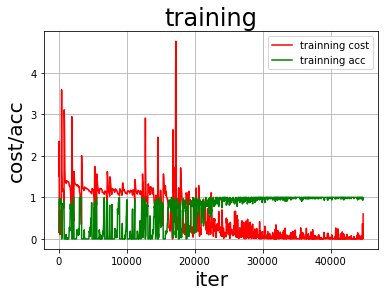

训练模型保存完成！


In [16]:

# 训练的轮数
EPOCH_NUM = 20
print('开始训练...')
#两种方法，用两个不同的路径分别保存训练的模型
#model_save_dir = "/home/aistudio/data/model_vgg"
model_save_dir = "E:\\Code\\Notebook\\FaceR\\data\\model_cnn"
for pass_id in range(EPOCH_NUM):
    train_cost = 0
    for batch_id, data in enumerate(train_reader()):                         #遍历train_reader的迭代器，并为数据加上索引batch_id
        train_cost, train_acc = exe.run(
            program=fluid.default_main_program(),                            #运行主程序
            feed=feeder.feed(data),                                          #喂入一个batch的数据
            fetch_list=[avg_cost, accuracy])                                 #fetch均方误差和准确率
        
        all_train_iter=all_train_iter+BATCH_SIZE
        all_train_iters.append(all_train_iter)
        all_train_costs.append(train_cost[0])
        all_train_accs.append(train_acc[0])
       
       
        if batch_id % 10 == 0:                                               #每10次batch打印一次训练、进行一次测试
            print("\nPass %d, Step %d, Cost %f, Acc %f" % 
            (pass_id, batch_id, train_cost[0], train_acc[0]))
    # 开始测试
    test_accs = []                                                            #测试的损失值
    test_costs = []                                                           #测试的准确率
    # 每训练一轮 进行一次测试
    for batch_id, data in enumerate(test_reader()):                           # 遍历test_reader
         test_cost, test_acc = exe.run(program=fluid.default_main_program(),  # #运行测试主程序
                                       feed=feeder.feed(data),                #喂入一个batch的数据
                                       fetch_list=[avg_cost, accuracy])       #fetch均方误差、准确率
         test_accs.append(test_acc[0])                                        #记录每个batch的误差
         test_costs.append(test_cost[0])                                      #记录每个batch的准确率

   # 求测试结果的平均值
    test_cost = (sum(test_costs) / len(test_costs))                           # 每轮的平均误差
    test_acc = (sum(test_accs) / len(test_accs))                              # 每轮的平均准确率
    print('Test:%d, Cost:%0.5f, ACC:%0.5f' % (pass_id, test_cost, test_acc))
    
   
    # 如果保存路径不存在就创建
    if not os.path.exists(model_save_dir):
        os.makedirs(model_save_dir)
    # 保存训练的模型，executor 把所有相关参数保存到 dirname 中
    fluid.io.save_inference_model(dirname=model_save_dir, 
                                    feeded_var_names=["image"],
                                    target_vars=[predict],
                                    executor=exe)
                                    
draw_train_process("training",all_train_iters,all_train_costs,all_train_accs,"trainning cost","trainning acc")

print('训练模型保存完成！')

开始训练...

Pass 0, Step 0, Cost 1.635762, Acc 0.187500

Pass 0, Step 10, Cost 0.001473, Acc 1.000000

Pass 0, Step 20, Cost 0.171592, Acc 0.906250
Test:0, Cost:10.19970, ACC:0.29315

Pass 1, Step 0, Cost 6.190961, Acc 0.062500

Pass 1, Step 10, Cost 0.550070, Acc 0.843750

Pass 1, Step 20, Cost 2.783452, Acc 0.843750
Test:1, Cost:7.33126, ACC:0.54167

Pass 2, Step 0, Cost 9.578829, Acc 0.031250

Pass 2, Step 10, Cost 1.258688, Acc 0.500000

Pass 2, Step 20, Cost 0.804791, Acc 0.812500
Test:2, Cost:2.50527, ACC:0.53125

Pass 3, Step 0, Cost 7.384169, Acc 0.031250

Pass 3, Step 10, Cost 0.390643, Acc 0.937500

Pass 3, Step 20, Cost 0.158680, Acc 0.968750
Test:3, Cost:2.62278, ACC:0.56250

Pass 4, Step 0, Cost 1.989927, Acc 0.281250

Pass 4, Step 10, Cost 0.242509, Acc 0.906250

Pass 4, Step 20, Cost 0.180008, Acc 0.968750
Test:4, Cost:2.23020, ACC:0.74454

Pass 5, Step 0, Cost 0.406810, Acc 0.937500

Pass 5, Step 10, Cost 0.082695, Acc 1.000000

Pass 5, Step 20, Cost 0.039385, Acc 1.000000

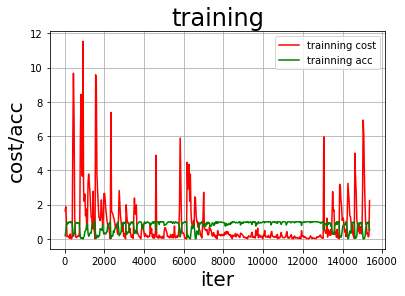

训练模型保存完成！


In [18]:
# 训练VGG模型
EPOCH_NUM = 20
print('开始训练...')
#两种方法，用两个不同的路径分别保存训练的模型
#model_save_dir = "/home/aistudio/data/model_vgg"
model_save_dir = "E:\\Code\\Notebook\\FaceR\\data\\model_vgg"
for pass_id in range(EPOCH_NUM):
    train_cost = 0
    for batch_id, data in enumerate(train_reader()):                         #遍历train_reader的迭代器，并为数据加上索引batch_id
        train_cost, train_acc = exe.run(
            program=fluid.default_main_program(),                            #运行主程序
            feed=feeder.feed(data),                                          #喂入一个batch的数据
            fetch_list=[avg_vgg_cost, accuracy_vgg])                                 #fetch均方误差和准确率
        
        all_train_iter=all_train_iter+BATCH_SIZE
        all_train_iters.append(all_train_iter)
        all_train_costs.append(train_cost[0])
        all_train_accs.append(train_acc[0])
       
       
        if batch_id % 10 == 0:                                               #每10次batch打印一次训练、进行一次测试
            print("\nPass %d, Step %d, Cost %f, Acc %f" % 
            (pass_id, batch_id, train_cost[0], train_acc[0]))
    # 开始测试
    test_accs = []                                                            #测试的损失值
    test_costs = []                                                           #测试的准确率
    # 每训练一轮 进行一次测试
    for batch_id, data in enumerate(test_reader()):                           # 遍历test_reader
         test_cost, test_acc = exe.run(program=fluid.default_main_program(),  # #运行测试主程序
                                       feed=feeder.feed(data),                #喂入一个batch的数据
                                       fetch_list=[avg_vgg_cost, accuracy_vgg])       #fetch均方误差、准确率
         test_accs.append(test_acc[0])                                        #记录每个batch的误差
         test_costs.append(test_cost[0])                                      #记录每个batch的准确率

   # 求测试结果的平均值
    test_cost = (sum(test_costs) / len(test_costs))                           # 每轮的平均误差
    test_acc = (sum(test_accs) / len(test_accs))                              # 每轮的平均准确率
    print('Test:%d, Cost:%0.5f, ACC:%0.5f' % (pass_id, test_cost, test_acc))
    
   
    # 如果保存路径不存在就创建
    if not os.path.exists(model_save_dir):
        os.makedirs(model_save_dir)
    # 保存训练的模型，executor 把所有相关参数保存到 dirname 中
    fluid.io.save_inference_model(dirname=model_save_dir, 
                                    feeded_var_names=["image"],
                                    target_vars=[predict],
                                    executor=exe)
                                    
draw_train_process("training",all_train_iters,all_train_costs,all_train_accs,"trainning cost","trainning acc")

print('训练模型保存完成！')

![](https://ai-studio-static-online.cdn.bcebos.com/3fbf0c185f2f49e382994788d8ac07f691742ab6199441059453fdac586c6afc)

# Step5.模型预测

下面是预测程序，直接单独运行In[*]就可以。预测主要有四步：第一步配置好预测的环境，第二步准备好要预测的图片，第三步加载预测的模型，把要预测的图片放到模型里进行预测，第四步输出预测的结果

infer_imgs的维度： (3, 100, 100)


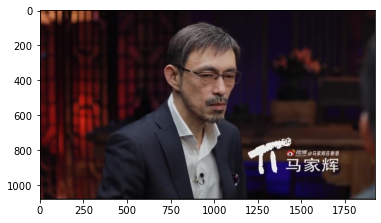

results: 2
[array([[0.03946423, 0.01714832, 0.911286  , 0.03210144]], dtype=float32)]
infer results: 马家辉


In [21]:
# coding:utf-8
import paddle.fluid as fluid
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import paddle

# 使用CPU进行训练
place = fluid.CPUPlace()
# 定义一个executor
infer_exe = fluid.Executor(place)
inference_scope = fluid.core.Scope()#要想运行一个网络，需要指明它运行所在的域，确切的说： exe.Run(&scope) 
#选择保存不同的训练模型
params_dirname ="E:\\Code\\Notebook\\FaceR\\data\\model_vgg"
#params_dirname ='/home/aistudio/data/model_vgg'

# （1）图片预处理
def load_image(path):
    img = paddle.dataset.image.load_and_transform(path,100,100, False).astype('float32')#img.shape是(3, 100, 100)
    img = img / 255.0 
    return img

infer_imgs = []
infer_path = []
dwt = 'E:\\Code\\Notebook\\FaceR\\1.png'
lwd = 'E:\\Code\\Notebook\\FaceR\\face_y\\liangwendao\\2.png'
mjh = 'E:\\Code\\Notebook\\FaceR\\face_y\\majiahui\\1.png'
zyj = 'E:\\Code\\Notebook\\FaceR\\face_y\\zhouyijun\\1.png'
infer_path.append((Image.open(dwt), load_image(dwt)))
infer_path.append((Image.open(lwd), load_image(lwd)))
infer_path.append((Image.open(mjh), load_image(mjh)))
infer_path.append((Image.open(zyj), load_image(zyj)))

print('infer_imgs的维度：',np.array(infer_path[0][1]).shape)

#fluid.scope_guard修改全局/默认作用域（scope）, 运行时中的所有变量都将分配给新的scope
with fluid.scope_guard(inference_scope):
     #获取训练好的模型
    #从指定目录中加载 推理model(inference model)
    [inference_program,# 预测用的program
     feed_target_names,# 是一个str列表，它包含需要在推理 Program 中提供数据的变量的名称。
     fetch_targets] = fluid.io.load_inference_model(params_dirname, infer_exe)#fetch_targets：是一个 Variable 列表，从中我们可以得到推断结果。

    image_and_path = infer_path[2]
    plt.imshow(image_and_path[0])   #根据数组绘制图像
    plt.show()        #显示图像

    # 开始预测
    results = infer_exe.run(
        inference_program,                      #运行预测程序
        feed={feed_target_names[0]: np.array([image_and_path[1]])},#喂入要预测的数据
        fetch_list=fetch_targets)               #得到推测结果
    print('results:',np.argmax(results[0]))

    # 训练数据的标签
    label_list = ["窦文涛", "梁文道", "马家辉", "周轶君"]
    print(results)
    print("infer results: %s" % label_list[np.argmax(results[0])])